In [3]:
import os
import csv
import numpy as np
import shutil
import matplotlib.pyplot as plt

# read train.csv, return list of tuples (filename,whale_name)
def read_csv(file_name = "data/train.csv"):

    if not os.path.isfile(file_name):
        print("{} no valid path".format(file_name))
        return None
    
    csv_list = []
    with open(file_name) as csvfile:
        reader = csv.reader(csvfile)
        for rows in reader:
            csv_list.append((rows[0],rows[1]))

    return csv_list[1:]

# write list of tuples (filename,whale_name) to csv file
def write_csv(csv_list, file_name = "data/small_train.csv"):
    
    if os.path.isfile(file_name):
        os.remove(file_name)
    
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Image'] + ['Id'])
        for entry in csv_list:
            writer.writerow([entry[0]] + [entry[1]])
            #spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
            #spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])


# generate sorted list clustered by individuals: (name, number of images, array of indeces into train_list)
def get_whales(train_list):
    
    train_arr = np.asarray(train_list)
    whale_names = np.unique(train_arr.T[1], axis=0)

    whales = []
    for name in whale_names:
        idx = np.where(train_arr.T[1] == name)[0]
        whales.append((name,idx.shape[0],idx)) 

    # sort by frequency of occurence in descending order 
    whales.sort(key=lambda x:x[1], reverse=True)
    counts=[whale[1] for whale in whales]      # list of numbers of individuals ([34,25,24...])

    return whales, counts

def show_histogram(num = 100, file_name = "data/train.csv"):
    train_list = read_csv(file_name = file_name)
    _, counts = get_whales(train_list)    
    plt.hist(counts[1:num], bins=counts[1], color="b", align = "left", rwidth=0.75)  # skip first entry "new whale"
    # plt.hist(counts[1:num], bins=num)  # skip first entry "new whale"
    plt.title("{} most frequent whales".format(num))
    plt.xlabel('number of images per individual')
    plt.ylabel('number of individuals')
    plt.show()

# alternative representation of frequencies of occurance    
def show_frequencies(num = 100, file_name = "data/train.csv"):
    train_list = read_csv(file_name = file_name)
    _, counts = get_whales(train_list)    
    num = min(num, len(counts)-1)   # avoid errors if num chosen larger than len(counts)
    plt.bar(np.arange(num),counts[1:num+1], color = 'b', edgecolor = 'b')
    plt.title("number of images per whale".format(num))
    plt.xlabel('individuals')
    plt.ylabel('number of images per individual')
    plt.show()

# plot list of given images    
def plot_whales(imgs, labels=None, rows=4):
    
    figure = plt.figure(figsize=(16, 10))
    cols = len(imgs) // rows + 1
    
    for i, img in enumerate(imgs):    
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        plt.imshow(img, cmap='gray')              
        if len(labels)>0:
            subplot.set_title(labels[i], fontsize=16)
            
# plot (all or first max_imgs) images of whale with number whale_no
# labeled with names, if required
def show_whales(whale_no, folder="data/train", csv_file="data/train.csv",
                max_imgs=100, rows=4, labels=False):
    
    train_list = read_csv(file_name = csv_file)
    whales, counts = get_whales(train_list)   # get list of whales ordered by frequency    
    print("Images of whale {}, number {} in list".format(whales[whale_no][0], whale_no))

    img_count = min(counts[whale_no], max_imgs)

    imgs = []
    label_list = []      # for future extensions with more than one individual
    idx = whales[whale_no][2]  
    for i in range(img_count):        
        fn = train_list[idx[i]][0]     # get filename out of train_csv list
        path = os.path.join(folder, fn)
        if os.path.isfile(path):
            imgs.append(plt.imread(path))
            if labels: 
                label_list.append(whales[whale_no][0])     
        else:
            print("invalid path: {}".format(path))
    
    plot_whales(imgs, labels=label_list, rows=rows)

           
# as a playground reproduce setting (image-files, csv-file, directory structure) 
# for small case (small number of selected individuals)
def create_small_case(sel_whales = [1,2,3],          # whales to be considered in case, by order of occurence
                      train_dir = "data/train",
                      train_csv = "data/train.csv",
                      small_dir = "data/small_train", 
                      small_csv = "data/small_train.csv"):

    if not os.path.isdir(train_dir):
        print("{} no valid directory".format(train_dir))
        return

    try: 
        shutil.rmtree(small_dir)   # remove directory, if already existing 
        print("old directory removed {}".format(small_dir))
    except:
        print("directory {} did not exist so far".format(small_dir))
    
    os.mkdir(small_dir)
    small_list=[]
    train_list = read_csv(file_name = train_csv)  # get list with (filenames, whalenames)
    whales, counts = get_whales(train_list)   # get list of whales ordered by frequency
    for i in sel_whales:                          
        # whale_idx = whales[i][2]                 # get list of indices of this whale
        print("copy {} images for whale # {} in ordered list, called {}"
              .format(whales[i][1], i, whales[i][0]))
        for idx in whales[i][2]:        # np array containing indices of this whale pointing into train_csv list  
            fn = train_list[idx][0]     # get filename out of train_csv list
            shutil.copy(os.path.join(train_dir, fn), 
                        os.path.join(small_dir, fn))
            
            small_list.append((fn,whales[i][0]))
    print("write csv file: {}".format(small_csv))            
    write_csv(small_list, small_csv)

# evaluation metrics    
# Precision at k is a percentage of correct items among first k recommendations
# "cut off k": only first occurence of matching prediction contributes to score
def precision_at_k(model_prediction, true_label, k):
    if model_prediction[k] == true_label and not true_label in model_prediction[:k]:
        return(1/(k+1))   # return precision = TP / total number of samples
    else:
        return(0)

# precision at cut-off k 
def average_precision(model_prediction, true_label, max_pred):
    average_precision = 0
    for k in range(max_pred):
        average_precision += precision_at_k(model_prediction, true_label, k)
    return average_precision # / min(len(true_label), max_pred)

# mean average precision is simply the mean of average_precision over several samples
def mean_average_precision(model_predictions, true_labels, max_pred):
    return np.mean([average_precision(mp, tl, max_pred) for mp, tl in zip(model_predictions, true_labels)])
   

In [4]:
train_list = read_csv(file_name = "data/train.csv")
whales, counts = get_whales(train_list)
print("{} individuals".format(len(counts)))  

4251 individuals


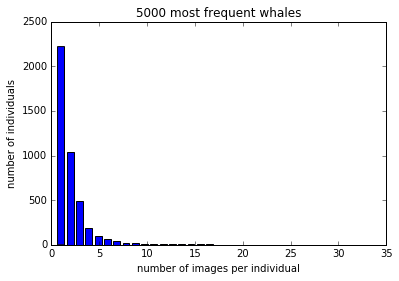

In [5]:
show_histogram(5000)  # histogram of up to 5000 first whales (= all whales, as total no is only 4251)

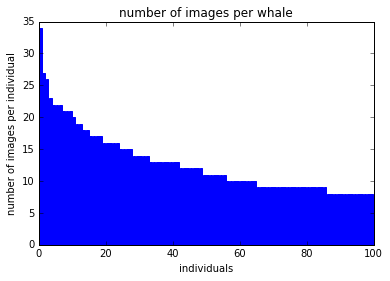

In [6]:
show_frequencies(100)   # number of occurences of the first 100 whales

Images of whale w_17ee910, number 20 in list


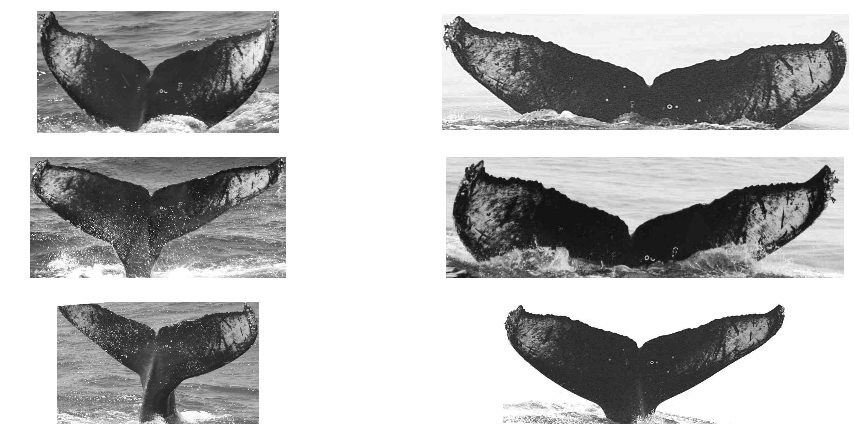

In [18]:
# show up do 6 images of whale nr. 20
show_whales(20, max_imgs=6)

In [10]:
# create toy environment with the images of the whales nr. 1,3 and 5 (ordered by number of occurences)
create_small_case(sel_whales = [1,3,5],
                  small_dir = "data/small_train",
                  small_csv = "data/small_train.csv") 

old directory removed data/small_train
copy 34 images for whale # 1 in ordered list, called w_1287fbc
copy 26 images for whale # 3 in ordered list, called w_7554f44
copy 22 images for whale # 5 in ordered list, called w_693c9ee
write csv file: data/small_train.csv


In [12]:
'''
As a benchmark we create a dumb model predicting whales randomly. 
We test, how this model performs on the training set when using the MAP@5 metric.
Assume, that a "dumb" model will map the images to the individuals randomly, 
'''

# def test_evaluate(test_csv"data/small_train.csv", "data/small_train"):
create_small_case(sel_whales = [1,2,3],
                  small_dir = "data/dumb_train", 
                  small_csv = "data/dumb_train.csv")
 
# train_list = read_csv(file_name = "data/dumb_train.csv")   # for testing toy data set
train_list = read_csv(file_name = "data/train.csv")   # for testing whole train data set

whales, counts = get_whales(train_list)
print("{} individuals".format(len(counts)))  

# to each image in train_list map a ranked list of max_pred whales
# as random number between 1 and # of individuals in scenario (as indeces in whale list)
max_pred = 5
dummy_preds = []
for i in range(len(train_list)):
    ranks = np.random.randint(0,len(counts),max_pred)
    dummy_preds.append(ranks)

true_labels = []

# get list of true labels: retrieve whale number from name
for i, img in enumerate(train_list):
    name = img[1]
    true_labels.append([i for i, whale in enumerate(whales) if whale[0] == name][0])

print("dummy_preds first 10: \n",dummy_preds[:10])
print("true_labels  first 50: \n",true_labels[:50])

MAP = mean_average_precision(dummy_preds, true_labels, max_pred)
print("\n map", MAP)

'''
Running this test on the whole training dataset returns an MAP of 0.00037563
The test set contains 15,610 images, compared to 9.850 in the training set. 
So the same performance check on the test set would yield a slightly worse performance. 
'''

old directory removed data/dumb_train
copy 34 images for whale # 1 in ordered list, called w_1287fbc
copy 27 images for whale # 2 in ordered list, called w_98baff9
copy 26 images for whale # 3 in ordered list, called w_7554f44
write csv file: data/dumb_train.csv
4251 individuals
dummy_preds first 10: 
 [array([3512, 1093, 2724, 3449, 3528]), array([3981, 1576, 1692, 1777,  280]), array([3151,  649, 2440, 3371, 1254]), array([4117,  548, 2799, 1789, 4129]), array([ 647, 3666, 3423, 2205, 3328]), array([ 628,  835, 3177,  238, 1050]), array([1725, 3436, 2896, 3428, 1203]), array([4216, 2462, 3184,  656,  512]), array([1306, 3111,  332, 3444,    8]), array([2098, 3071, 1896, 2739,  795])]
true_labels  first 50: 
 [3978, 1, 55, 2234, 1984, 772, 4058, 0, 62, 662, 340, 2957, 796, 7, 689, 828, 406, 3763, 945, 0, 0, 744, 274, 860, 3597, 1175, 0, 664, 1324, 282, 0, 1230, 46, 579, 76, 2915, 1658, 1606, 566, 1237, 0, 183, 816, 2373, 38, 442, 3083, 4097, 1634, 664]

 map 0.000375634517766


'\nThe test set contains 15,610 images, compared to 9.850 in the training set. \nSo the same performance check on the test set would yield a worse performance. \n'